In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE


# Load dataset
df = pd.read_csv("creditcard.csv")
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [2]:
# Check class distribution
print("Class distribution:\n", df['Class'].value_counts())

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


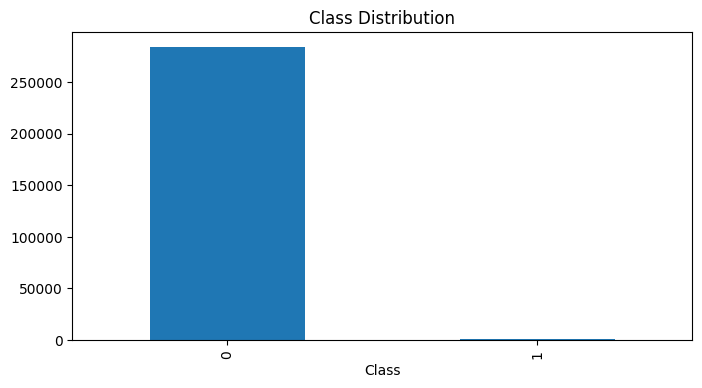

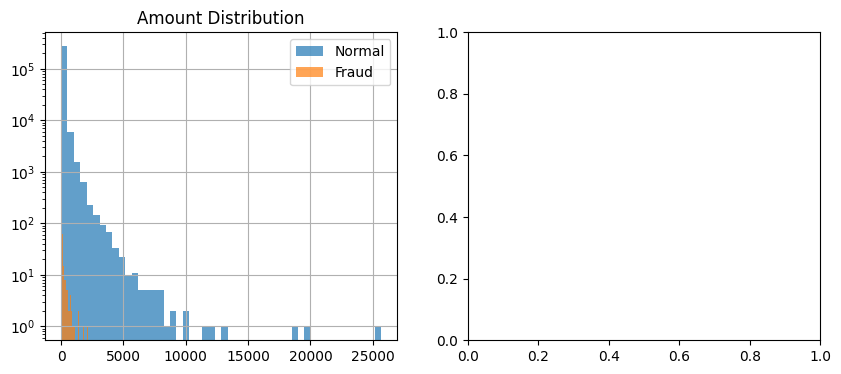

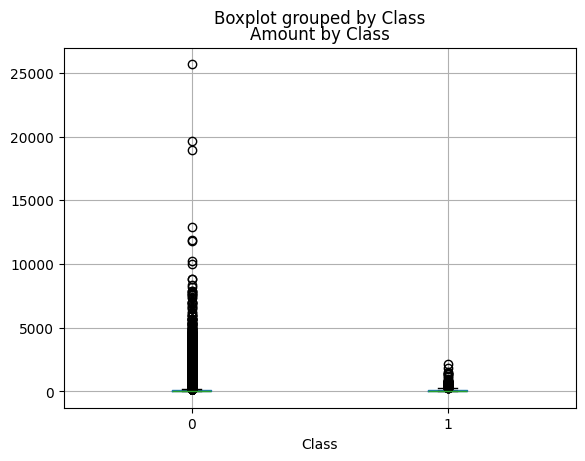

In [3]:
# EXPLORATORY DATA ANALYSIS
# Class distribution
plt.figure(figsize=(8, 4))
df['Class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

# Amount comparison
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df[df['Class']==0]['Amount'].hist(bins=50, alpha=0.7, label='Normal')
df[df['Class']==1]['Amount'].hist(bins=50, alpha=0.7, label='Fraud')
plt.legend()
plt.title('Amount Distribution')
plt.yscale('log')

plt.subplot(1, 2, 2)
df.boxplot(column='Amount', by='Class')
plt.title('Amount by Class')
plt.show()

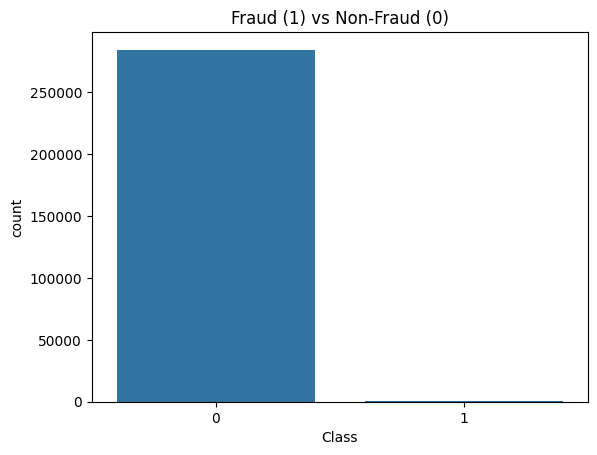

In [4]:
sns.countplot(x='Class', data=df)
plt.title("Fraud (1) vs Non-Fraud (0)")
plt.show()

In [5]:
# Features and labels
X = df.drop('Class', axis=1)
y = df['Class']

In [6]:
# Scale 'Amount' and 'Time' since they are not PCA transformed
scaler = StandardScaler()
X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # This ensures both train and test sets have the same proportion of fraud/non-fraud
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTraining set class distribution:")
print(y_train.value_counts())
print("\nTest set class distribution:")
print(y_test.value_counts())

Training set shape: (227845, 30)
Test set shape: (56962, 30)

Training set class distribution:
Class
0    227451
1       394
Name: count, dtype: int64

Test set class distribution:
Class
0    56864
1       98
Name: count, dtype: int64


In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# --- Option 1: Partial SMOTE (minority = 50% of majority) 
smote_partial = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote_partial, y_train_smote_partial = smote_partial.fit_resample(X_train, y_train)

print("After Partial SMOTE (50%) - Training set shape:", X_train_smote_partial.shape)
print("Class distribution after Partial SMOTE:")
print(pd.Series(y_train_smote_partial).value_counts())
print(f"Class balance ratio: {pd.Series(y_train_smote_partial).value_counts()[1] / pd.Series(y_train_smote_partial).value_counts()[0]:.3f}\n")

# --- Option 2: Under-sampling the majority class 
under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  
# majority will be twice minority
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

print("After Random Undersampling (majority = 2x minority) - Training set shape:", X_train_under.shape)
print("Class distribution after Undersampling:")
print(pd.Series(y_train_under).value_counts())
print(f"Class balance ratio: {pd.Series(y_train_under).value_counts()[1] / pd.Series(y_train_under).value_counts()[0]:.3f}\n")

After Partial SMOTE (50%) - Training set shape: (341176, 30)
Class distribution after Partial SMOTE:
Class
0    227451
1    113725
Name: count, dtype: int64
Class balance ratio: 0.500

After Random Undersampling (majority = 2x minority) - Training set shape: (1182, 30)
Class distribution after Undersampling:
Class
0    788
1    394
Name: count, dtype: int64
Class balance ratio: 0.500



In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(X_train, y_train, X_test, y_test, label):
    # Train Logistic Regression
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = lr_model.predict(X_test)
    y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
    
    # Metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    return lr_model

#  Train and evaluate on Partial SMOTE (1:2 ratio) 
lr_smote_partial = evaluate_model(X_train_smote_partial, y_train_smote_partial, X_test, y_test, "Logistic Regression - Partial SMOTE (1:2)")

#Train and evaluate on Undersampled (2:1 ratio)
lr_undersampled = evaluate_model(X_train_under, y_train_under, X_test, y_test, "Logistic Regression - Undersampling (2:1)")


Precision: 0.1059
Recall:    0.8980
F1-score:  0.1895
ROC-AUC:   0.9681
Confusion Matrix:
[[56121   743]
 [   10    88]]
Precision: 0.0602
Recall:    0.9184
F1-score:  0.1131
ROC-AUC:   0.9744
Confusion Matrix:
[[55460  1404]
 [    8    90]]


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_rf(X_train, y_train, X_test, y_test, label):
    # Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f" {label} ")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    return rf_model

#  Train and evaluate on Partial SMOTE (1:2 ratio)
rf_smote_partial = evaluate_rf(X_train_smote_partial, y_train_smote_partial, X_test, y_test, "Random Forest - Partial SMOTE (1:2)")

# Train and evaluate on Undersampled (2:1 ratio)
rf_undersampled = evaluate_rf(X_train_under, y_train_under, X_test, y_test, "Random Forest - Undersampling (2:1)")


 Random Forest - Partial SMOTE (1:2) 
Precision: 0.8617
Recall:    0.8265
F1-score:  0.8438
ROC-AUC:   0.9727
Confusion Matrix:
[[56851    13]
 [   17    81]]
 Random Forest - Undersampling (2:1) 
Precision: 0.0827
Recall:    0.8980
F1-score:  0.1515
ROC-AUC:   0.9769
Confusion Matrix:
[[55888   976]
 [   10    88]]


In [12]:
import pandas as pd

# Store your results manually (from the outputs you posted)
results = [
    {"Model": "Random Forest - Partial SMOTE (1:2)", "Precision": 0.8617, "Recall": 0.8265, "F1-score": 0.8438, "ROC-AUC": 0.9727},
    {"Model": "Random Forest - Undersampling (2:1)", "Precision": 0.0827, "Recall": 0.8980, "F1-score": 0.1515, "ROC-AUC": 0.9769},
    {"Model": "Logistic - Partial SMOTE (1:2)", "Precision": 0.1059, "Recall": 0.8980, "F1-score": 0.1895, "ROC-AUC": 0.9681},
    {"Model": "Logistic - Undersampling (2:1)", "Precision": 0.0602, "Recall": 0.9184, "F1-score": 0.1131, "ROC-AUC": 0.9744},
]

# Convert to DataFrame for easy comparison
df_results = pd.DataFrame(results)

print(df_results)


                                 Model  Precision  Recall  F1-score  ROC-AUC
0  Random Forest - Partial SMOTE (1:2)     0.8617  0.8265    0.8438   0.9727
1  Random Forest - Undersampling (2:1)     0.0827  0.8980    0.1515   0.9769
2       Logistic - Partial SMOTE (1:2)     0.1059  0.8980    0.1895   0.9681
3       Logistic - Undersampling (2:1)     0.0602  0.9184    0.1131   0.9744


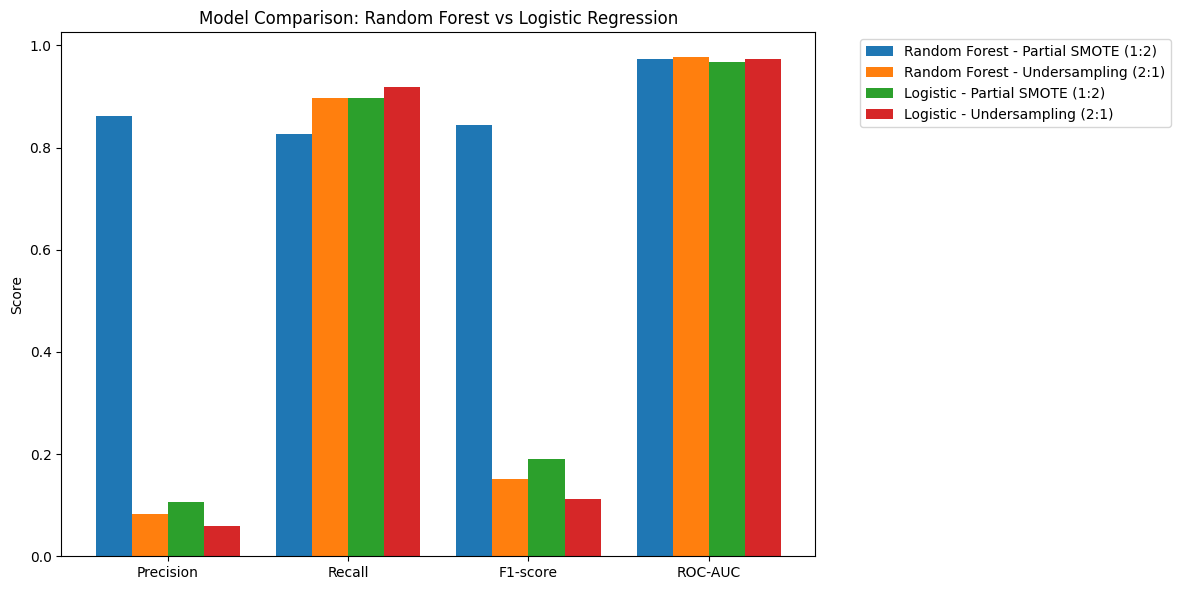

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Results table
results = pd.DataFrame({
    "Model": [
        "Random Forest - Partial SMOTE (1:2)",
        "Random Forest - Undersampling (2:1)",
        "Logistic - Partial SMOTE (1:2)",
        "Logistic - Undersampling (2:1)"
    ],
    "Precision": [0.8617, 0.0827, 0.1059, 0.0602],
    "Recall": [0.8265, 0.8980, 0.8980, 0.9184],
    "F1-score": [0.8438, 0.1515, 0.1895, 0.1131],
    "ROC-AUC": [0.9727, 0.9769, 0.9681, 0.9744]
})

# Plot grouped bar chart
metrics = ["Precision", "Recall", "F1-score", "ROC-AUC"]
x = range(len(metrics))
width = 0.2

plt.figure(figsize=(12, 6))

for i, row in enumerate(results.values):
    plt.bar(
        [p + i*width for p in x],
        row[1:],  # Skip model name
        width=width,
        label=row[0]
    )

plt.xticks([p + 1.5*width for p in x], metrics)
plt.ylabel("Score")
plt.title("Model Comparison: Random Forest vs Logistic Regression")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Define evaluation metrics
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)

# Partial SMOTE (1:2 ratio)
smote = SMOTE(sampling_strategy=0.5, random_state=42)

# Build pipeline: SMOTE + RandomForest
model = Pipeline(steps=[('smote', smote), ('rf', rf)])

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_results = cross_validate(
    model, X_train, y_train, 
    scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False
)

# Summarize results
results = {
    "Precision": np.mean(cv_results['test_precision']),
    "Recall": np.mean(cv_results['test_recall']),
    "F1-score": np.mean(cv_results['test_f1']),
    "ROC-AUC": np.mean(cv_results['test_roc_auc'])
}

df_results = pd.DataFrame([results], index=["Random Forest + Partial SMOTE (1:2)"])
print(df_results)


                                     Precision    Recall  F1-score  ROC-AUC
Random Forest + Partial SMOTE (1:2)   0.887599  0.804576  0.842219  0.97095



1. OPTIMIZING PREDICTION THRESHOLD
Optimal threshold: 0.7100
F1-score at optimal threshold: 0.8603
Precision at optimal threshold: 0.9506
Recall at optimal threshold: 0.7857


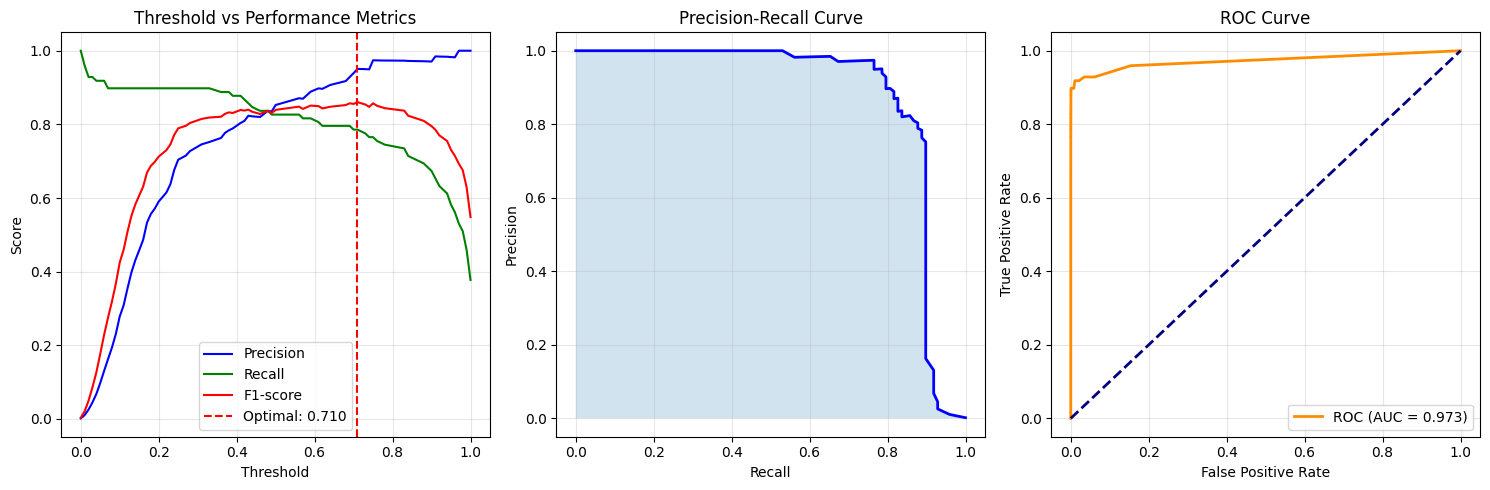

In [24]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
# STEP 1: THRESHOLD OPTIMIZATION 
print("\n1. OPTIMIZING PREDICTION THRESHOLD")


# Get prediction probabilities from your best model
y_proba = rf_smote_partial.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"F1-score at optimal threshold: {f1_scores[optimal_idx]:.4f}")
print(f"Precision at optimal threshold: {precision[optimal_idx]:.4f}")
print(f"Recall at optimal threshold: {recall[optimal_idx]:.4f}")

# Plot threshold optimization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green') 
plt.plot(thresholds, f1_scores[:-1], label='F1-score', color='red')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Threshold vs Performance Metrics')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(recall, precision, color='blue', lw=2)
plt.fill_between(recall, precision, alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


2. ANALYZING FEATURE IMPORTANCE
Top 15 Most Important Features:
   feature  importance
14     V14    0.192592
10     V10    0.120388
12     V12    0.099270
17     V17    0.097030
4       V4    0.087968
11     V11    0.059163
16     V16    0.057866
3       V3    0.051447
2       V2    0.037382
9       V9    0.026177
7       V7    0.018278
21     V21    0.015881
27     V27    0.014014
18     V18    0.012291
8       V8    0.011717


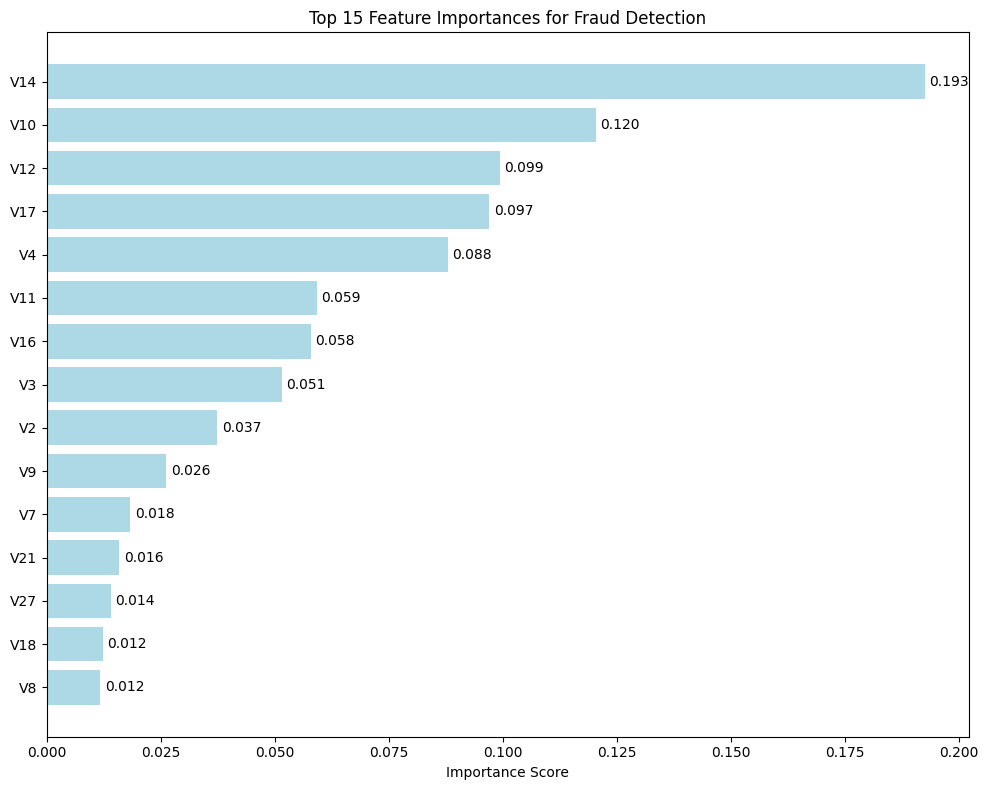

In [25]:
print("\n2. ANALYZING FEATURE IMPORTANCE")


# Get feature importances
importances = rf_smote_partial.feature_importances_
feature_names = X_train.columns

# Create importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance_df.head(15))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_15 = feature_importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='lightblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances for Fraud Detection')
plt.gca().invert_yaxis()

# Add values on bars
for i, v in enumerate(top_15['importance']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()


In [27]:
print("\n3. DETAILED MODEL EVALUATION")

# Make predictions with optimal threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
y_pred_default = rf_smote_partial.predict(X_test)

print(f"RESULTS WITH OPTIMAL THRESHOLD ({optimal_threshold:.4f}):")

print(classification_report(y_test, y_pred_optimal))

print(f"\nConfusion Matrix (Optimal Threshold):")
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
print(cm_optimal)

# Calculate business metrics
tn, fp, fn, tp = cm_optimal.ravel()

print(f"\nBUSINESS METRICS:")
print(f"True Positives (Frauds Caught): {tp}")
print(f"False Positives (False Alarms): {fp}") 
print(f"False Negatives (Missed Frauds): {fn}")
print(f"True Negatives (Correct Normal): {tn}")

fraud_detection_rate = tp / (tp + fn) * 100
false_alarm_rate = fp / (fp + tn) * 100

print(f"Fraud Detection Rate: {fraud_detection_rate:.1f}%")
print(f"False Alarm Rate: {false_alarm_rate:.2f}%")

# Financial impact estimate
avg_fraud_amount = 100  # $100 average fraud transaction
investigation_cost = 25   # $25 per investigation

fraud_prevented = tp * avg_fraud_amount
investigation_costs = (tp + fp) * investigation_cost
missed_fraud_losses = fn * avg_fraud_amount
net_benefit = fraud_prevented - investigation_costs - missed_fraud_losses

print(f"\nESTIMATED FINANCIAL IMPACT:")
print(f"Fraud Prevented: ${fraud_prevented:,}")
print(f"Investigation Costs: ${investigation_costs:,}")
print(f"Missed Fraud Losses: ${missed_fraud_losses:,}")
print(f"NET BENEFIT: ${net_benefit:,}")

# Compare with default threshold
print(f"\nCOMPARISON:")
cm_default = confusion_matrix(y_test, y_pred_default)
tn_def, fp_def, fn_def, tp_def = cm_default.ravel()
print(f"Optimal Threshold ({optimal_threshold:.3f}): TP={tp}, FP={fp}, FN={fn}")
print(f"Default Threshold (0.500): TP={tp_def}, FP={fp_def}, FN={fn_def}")


3. DETAILED MODEL EVALUATION
RESULTS WITH OPTIMAL THRESHOLD (0.7100):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.79      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix (Optimal Threshold):
[[56860     4]
 [   21    77]]

BUSINESS METRICS:
True Positives (Frauds Caught): 77
False Positives (False Alarms): 4
False Negatives (Missed Frauds): 21
True Negatives (Correct Normal): 56860
Fraud Detection Rate: 78.6%
False Alarm Rate: 0.01%

ESTIMATED FINANCIAL IMPACT:
Fraud Prevented: $7,700
Investigation Costs: $2,025
Missed Fraud Losses: $2,100
NET BENEFIT: $3,575

COMPARISON:
Optimal Threshold (0.710): TP=77, FP=4, FN=21
Default Threshold (0.500): TP=81, FP=13, FN=17


In [28]:
import joblib
import pandas as pd
import numpy as np
import json
# Save the model
joblib.dump(rf_smote_partial, 'fraud_detection_model.pkl')
joblib.dump(scaler, 'fraud_scaler.pkl')

# Create model configuration
model_config = {
    'optimal_threshold': float(optimal_threshold),
    'model_type': 'RandomForest_with_SMOTE',
    'performance': {
        'precision': precision[optimal_idx],
        'recall': recall[optimal_idx], 
        'f1_score': f1_scores[optimal_idx],
        'roc_auc': float(roc_auc)
    },
    'business_metrics': {
        'fraud_detection_rate': float(fraud_detection_rate),
        'false_alarm_rate': float(false_alarm_rate),
        'net_benefit': int(net_benefit)
    },
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print("✅ Model saved: fraud_detection_model.pkl")
print("✅ Scaler saved: fraud_scaler.pkl") 

✅ Model saved: fraud_detection_model.pkl
✅ Scaler saved: fraud_scaler.pkl
